# Predict Business risk

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from preprocess import prepare_input

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

Path("./visualization_images").mkdir(parents=True, exist_ok=True)

In [3]:
# Read the csv files in appropriate data frames

train_path = "./assignment_data/assignment_train.csv"
test_path = "./assignment_data/assignment_test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.sample(5)

,agent_id,3M_all_min,3M_all_max,3M_all_avg,3M_weekly_all_avg,3M_daily_all_avg,7days_all_gap_days,all_gap_7days_last_vs_previous,30days_all_gap_days,all_gap_30days_last_vs_previous,...,all_gtv_last10days_d1,all_gtv_last10days_d2,all_gtv_last10days_d3,all_gtv_last10days_d4,all_gtv_last10days_d5,all_gtv_last10days_d6,all_gtv_last10days_d7,all_gtv_last10days_d8,all_gtv_last10days_d9,business_risk
36841,36842,113367.0,160397.0,132547.6667,7119.166667,949.222222,0,0.000000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.600000
11025,11026,0.0,0.0,0.0000,818.916667,109.188889,0,0.000000,29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.033333
10037,10038,5001.0,5001.0,1667.0000,0.000000,0.000000,0,0.000000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.233333
35549,35550,50006.0,64681.0,38229.0000,0.000000,0.000000,0,0.000000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.233333
34989,34990,183145.0,825796.0,542622.3333,103447.666700,13793.022220,4,1.333333,10,1.0,...,0.0,21042.0,28103.0,18601.0,0.0,0.0,0.0,0.0,25702.0,7.300000


In [4]:
train_df = train_df.drop(labels=['agent_id'], axis=1)

In [5]:
target = ['business_risk']
y = train_df[target]
train_df = train_df.drop(labels=['business_risk'], axis=1)

### Data Preprocessing

In [6]:
print("Differnt types of columns in train data:", *list(train_df.dtypes.unique()))
print("Differnt types of columns in test data:", *list(test_df.dtypes.unique()))

print("Shape of train data:", train_df.shape)
print("Shape of test data:", test_df.shape)

print("All the columns in train data are also present in test data:", train_df.columns.values.tolist() == train_df.columns.values.tolist())

Differnt types of columns in train data: float64 int64
Differnt types of columns in test data: int64 float64
Shape of train data: (44616, 92)
Shape of test data: (21976, 93)
All the columns in train data are also present in test data: True


In [7]:
# Checking for any na values
print("Any missing value in train data:", train_df.isna().values.any())
print("Any missing value in test data:", test_df.isna().values.any())

Any missing value in train data: False
Any missing value in test data: False


**Note**: There are no missing values and both the data frame seems to be in order, we can proceed to EDA

### Exploratory Data Analysis

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44616 entries, 0 to 44615
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   3M_all_min                       44616 non-null  float64
 1   3M_all_max                       44616 non-null  float64
 2   3M_all_avg                       44616 non-null  float64
 3   3M_weekly_all_avg                44616 non-null  float64
 4   3M_daily_all_avg                 44616 non-null  float64
 5   7days_all_gap_days               44616 non-null  int64  
 6   all_gap_7days_last_vs_previous   44616 non-null  float64
 7   30days_all_gap_days              44616 non-null  int64  
 8   all_gap_30days_last_vs_previous  44616 non-null  float64
 9   mtd_all_gap_days                 44616 non-null  int64  
 10  all_gap_mtd_previous_days        44616 non-null  float64
 11  3M_all_gap_avg                   44616 non-null  float64
 12  12M_all_gap_avg   

In [9]:
train_df.describe()

,3M_all_min,3M_all_max,3M_all_avg,3M_weekly_all_avg,3M_daily_all_avg,7days_all_gap_days,all_gap_7days_last_vs_previous,30days_all_gap_days,all_gap_30days_last_vs_previous,mtd_all_gap_days,...,all_gtv_last10weeks_w10,all_gtv_last10days_d1,all_gtv_last10days_d2,all_gtv_last10days_d3,all_gtv_last10days_d4,all_gtv_last10days_d5,all_gtv_last10days_d6,all_gtv_last10days_d7,all_gtv_last10days_d8,all_gtv_last10days_d9
count,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,...,4.461600e+04,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,4.461600e+04
mean,1.370365e+05,2.719373e+05,1.932542e+05,4.684217e+04,6245.622675,1.268939,0.471734,8.004550,0.768911,7.895127,...,4.873591e+04,4872.929132,6709.762544,7323.079147,4736.388272,10349.086021,9202.802032,5980.615807,4705.416334,8.468645e+03
std,4.661570e+05,2.112051e+06,1.406972e+06,1.252489e+05,16699.849375,1.954257,0.818744,10.073897,1.297294,10.033567,...,1.559929e+05,17668.881137,21674.453195,24821.822718,18132.642334,32171.136031,29445.365819,20680.976872,20452.893930,2.750444e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,5.439000e+03,3.223250e+04,1.602867e+04,4.797708e+03,639.694444,0.000000,0.000000,2.000000,0.500000,2.000000,...,2.490000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,8.211625e+04,2.298552e+05,1.433834e+05,3.911598e+04,5215.463889,2.000000,0.857143,16.000000,1.066667,16.000000,...,3.170025e+04,1100.000000,2559.000000,2560.000000,700.250000,5018.500000,4010.000000,1500.000000,400.000000,3.176000e+03
max,2.799690e+07,4.204223e+08,2.748723e+08,3.542414e+06,472321.877800,6.000000,6.000000,29.000000,29.000000,28.000000,...,5.780761e+06,610885.000000,774350.000000,852843.000000,684693.000000,870922.000000,816736.000000,574411.000000,763653.000000,1.068293e+06


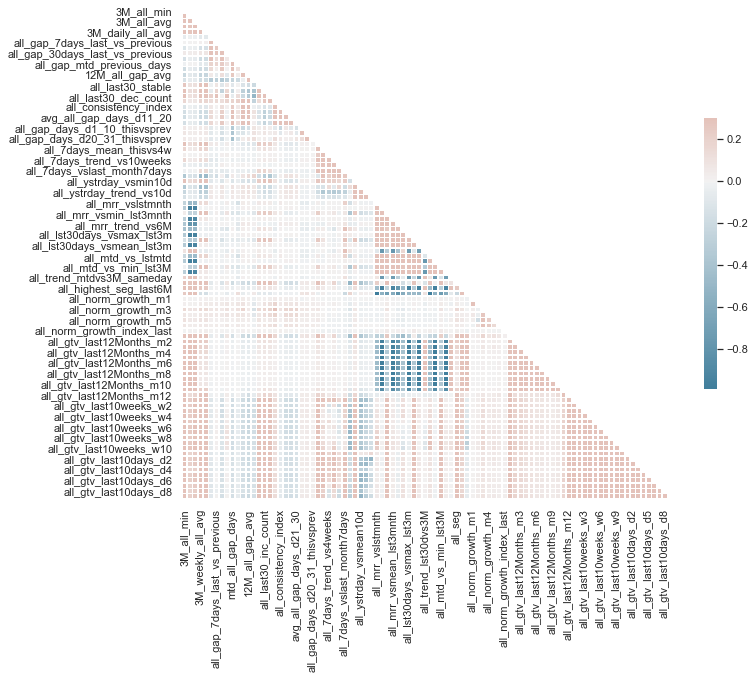

In [10]:
f, ax = plt.subplots(figsize=(11, 10))
corr = train_df.corr()
corr_plot = sns.heatmap(corr, 
                mask=np.triu(np.ones_like(corr, dtype=bool)), 
                cmap=sns.diverging_palette(230, 20, as_cmap=True),
                vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_plot.figure.savefig("./visualization_images/correlation_plot.png")

In [11]:
def get_corrlated_features_and_values(corr, threshold):
    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                colname = corr.columns[i]
                correlated_features.add(colname)
    return correlated_features, len(correlated_features)/ corr.shape[0]

In [12]:
corr_thresholds = [0.8, 0.85, 0.9, 0.95]
for threshold in corr_thresholds:
    features, corr_prc = get_corrlated_features_and_values(corr, threshold)
    print(f"The % is correlated features with threshold {threshold} is: {round(corr_prc, 3)}")

The % is correlated features with threshold 0.8 is: 0.511
The % is correlated features with threshold 0.85 is: 0.467
The % is correlated features with threshold 0.9 is: 0.37
The % is correlated features with threshold 0.95 is: 0.25


> Here I choose the threshold for correlation as 0.9 as I also plan to further reduce the dimensions by using PCA
Also `since the number of independent variables are large and almost 50% of them are highly correlated, I am not using VIF` to measure the strength [It will lead to values closer to infinity in few cases].

### Checking the variables semantically

#### Checking for `revenue` generated over different time periods

In [13]:
revenue_df = train_df.filter(regex='gtv')
revenue_month_df = revenue_df.filter(regex='Months')
revenue_week_df = revenue_df.filter(regex='weeks')
revenue_day_df = revenue_df.filter(regex='days')
revenue_df.describe()

,all_gtv_last12Months_m1,all_gtv_last12Months_m2,all_gtv_last12Months_m3,all_gtv_last12Months_m4,all_gtv_last12Months_m5,all_gtv_last12Months_m6,all_gtv_last12Months_m7,all_gtv_last12Months_m8,all_gtv_last12Months_m9,all_gtv_last12Months_m10,...,all_gtv_last10weeks_w10,all_gtv_last10days_d1,all_gtv_last10days_d2,all_gtv_last10days_d3,all_gtv_last10days_d4,all_gtv_last10days_d5,all_gtv_last10days_d6,all_gtv_last10days_d7,all_gtv_last10days_d8,all_gtv_last10days_d9
count,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,...,4.461600e+04,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,4.461600e+04
mean,2.025594e+05,1.936670e+05,1.835363e+05,1.430892e+05,1.325442e+05,1.245782e+05,1.193055e+05,1.041709e+05,9.748940e+04,9.224540e+04,...,4.873591e+04,4872.929132,6709.762544,7323.079147,4736.388272,10349.086021,9202.802032,5980.615807,4705.416334,8.468645e+03
std,6.025051e+05,1.860919e+06,2.073711e+06,2.138344e+06,2.266116e+06,2.621544e+06,2.526895e+06,2.449305e+06,3.079397e+06,2.042011e+06,...,1.559929e+05,17668.881137,21674.453195,24821.822718,18132.642334,32171.136031,29445.365819,20680.976872,20452.893930,2.750444e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,9.119000e+03,5.558500e+03,2.924000e+03,3.840000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.490000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,1.464398e+05,1.330050e+05,1.148212e+05,7.786175e+04,6.208925e+04,5.310900e+04,4.537800e+04,3.475959e+04,1.998325e+04,1.005225e+04,...,3.170025e+04,1100.000000,2559.000000,2560.000000,700.250000,5018.500000,4010.000000,1500.000000,400.000000,3.176000e+03
max,2.799690e+07,3.761976e+08,4.204223e+08,4.421414e+08,4.703876e+08,5.478557e+08,5.276561e+08,5.124229e+08,6.470788e+08,4.255882e+08,...,5.780761e+06,610885.000000,774350.000000,852843.000000,684693.000000,870922.000000,816736.000000,574411.000000,763653.000000,1.068293e+06


#### Compressing Revenue - `month, week, day`

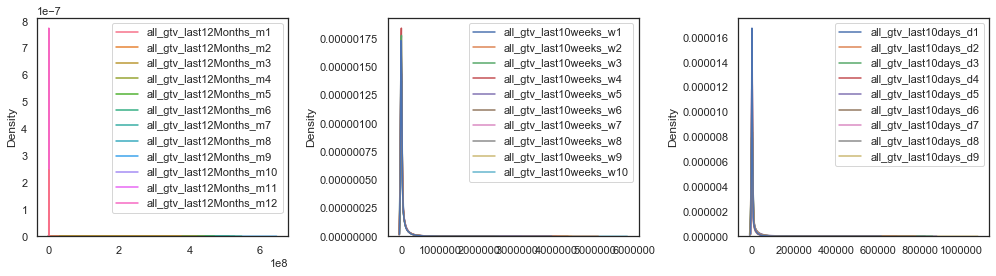

In [14]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))
revenue_arr = [revenue_month_df, revenue_week_df, revenue_day_df]
for i, df in enumerate(revenue_arr):
    sns.kdeplot(data=df, ax=axes[i], legend=True)
plt.tight_layout()

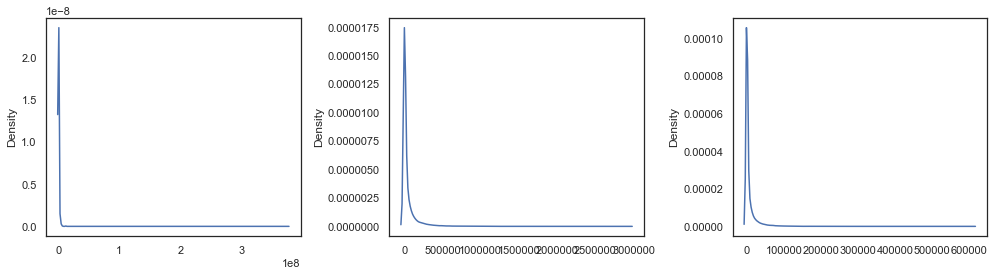

In [15]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))
revenue_arr = [revenue_month_df, revenue_week_df, revenue_day_df]
for i, df in enumerate(revenue_arr):
    sns.kdeplot(data=df.mean(axis=1), ax=axes[i], legend=False)
plt.tight_layout()

In [16]:
dfs = [revenue_month_df, revenue_week_df, revenue_day_df]

for df in dfs:
    revenue_scaler = StandardScaler()
    scaled_df = revenue_scaler.fit_transform(df)
    revenue_pca = PCA(0.93)
    revenue_pca.fit_transform(scaled_df)
    print(revenue_pca.explained_variance_ratio_)

[0.82514375 0.11380034]
[0.83930286 0.05108651 0.02800101 0.01868221]
[0.70344191 0.06338375 0.05916365 0.0399337  0.03625118 0.03049585]


In [17]:
revenue_df.describe()

,all_gtv_last12Months_m1,all_gtv_last12Months_m2,all_gtv_last12Months_m3,all_gtv_last12Months_m4,all_gtv_last12Months_m5,all_gtv_last12Months_m6,all_gtv_last12Months_m7,all_gtv_last12Months_m8,all_gtv_last12Months_m9,all_gtv_last12Months_m10,...,all_gtv_last10weeks_w10,all_gtv_last10days_d1,all_gtv_last10days_d2,all_gtv_last10days_d3,all_gtv_last10days_d4,all_gtv_last10days_d5,all_gtv_last10days_d6,all_gtv_last10days_d7,all_gtv_last10days_d8,all_gtv_last10days_d9
count,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,...,4.461600e+04,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,4.461600e+04
mean,2.025594e+05,1.936670e+05,1.835363e+05,1.430892e+05,1.325442e+05,1.245782e+05,1.193055e+05,1.041709e+05,9.748940e+04,9.224540e+04,...,4.873591e+04,4872.929132,6709.762544,7323.079147,4736.388272,10349.086021,9202.802032,5980.615807,4705.416334,8.468645e+03
std,6.025051e+05,1.860919e+06,2.073711e+06,2.138344e+06,2.266116e+06,2.621544e+06,2.526895e+06,2.449305e+06,3.079397e+06,2.042011e+06,...,1.559929e+05,17668.881137,21674.453195,24821.822718,18132.642334,32171.136031,29445.365819,20680.976872,20452.893930,2.750444e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,9.119000e+03,5.558500e+03,2.924000e+03,3.840000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.490000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,1.464398e+05,1.330050e+05,1.148212e+05,7.786175e+04,6.208925e+04,5.310900e+04,4.537800e+04,3.475959e+04,1.998325e+04,1.005225e+04,...,3.170025e+04,1100.000000,2559.000000,2560.000000,700.250000,5018.500000,4010.000000,1500.000000,400.000000,3.176000e+03
max,2.799690e+07,3.761976e+08,4.204223e+08,4.421414e+08,4.703876e+08,5.478557e+08,5.276561e+08,5.124229e+08,6.470788e+08,4.255882e+08,...,5.780761e+06,610885.000000,774350.000000,852843.000000,684693.000000,870922.000000,816736.000000,574411.000000,763653.000000,1.068293e+06


`
This shows that using pca we would need a lot more variables to compress the data, but as we can visually see, we can capture all these patterns in 3 variables - or even 1 - as they all show a smiliar trend.
`

### Comparing Growth

In [18]:
growth_df = train_df.filter(regex='growth')
growth_df.describe()

,all_growth_index,all_norm_growth_m1,all_norm_growth_m2,all_norm_growth_m3,all_norm_growth_m4,all_norm_growth_m5,all_norm_growth_m6,all_norm_growth_index_last
count,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000,44616.000000
mean,1.907298,0.057701,0.049074,0.169902,0.044578,0.031331,0.021300,7.273982
std,1.317939,0.630671,0.151375,0.254289,0.090228,0.117907,0.055846,566.033663
min,0.000000,-0.356535,-0.431895,-0.020711,-0.316170,-0.537598,-0.563319,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,3.000000,0.078795,0.026169,0.125179,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.092477,0.097744,0.286609,0.066158,0.066634,0.017827,0.000000
max,4.000000,58.905161,10.922423,5.402200,1.380439,2.836273,1.440625,97730.000000


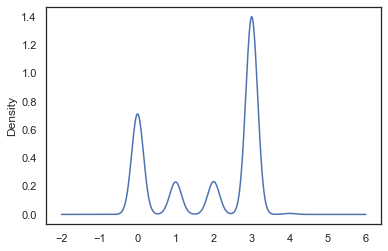

In [19]:
growth_df['all_growth_index'].plot.kde()
plt.show()

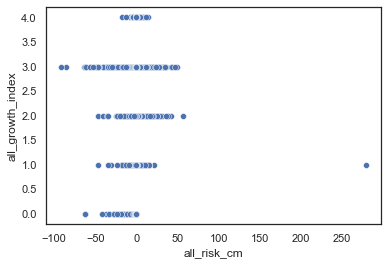

In [20]:
sns.scatterplot(x=train_df['all_risk_cm'], y=train_df['all_growth_index'], )

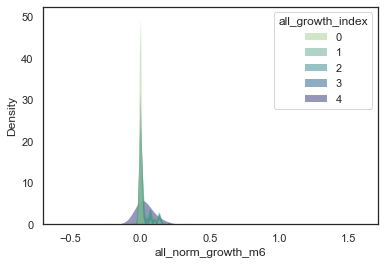

In [21]:
sns.kdeplot(
   data=growth_df, 
    x="all_norm_growth_m6", 
    hue="all_growth_index",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)

In [22]:
growth_df['all_norm_growth_m1'].describe()

count    44616.000000
mean         0.057701
std          0.630671
min         -0.356535
25%          0.000000
50%          0.078795
75%          0.092477
max         58.905161
Name: all_norm_growth_m1, dtype: float64

**Note:** Can't make out what growth index is and what the related variables are

#### Checking for `3 Months` transactions

In [23]:
months_3_df = train_df.filter(regex="^3M")
months_3_df = months_3_df.drop(labels=['3M_all_gap_avg'], axis=1)
months_3_df.describe()

,3M_all_min,3M_all_max,3M_all_avg,3M_weekly_all_avg,3M_daily_all_avg
count,4.461600e+04,4.461600e+04,4.461600e+04,4.461600e+04,44616.000000
mean,1.370365e+05,2.719373e+05,1.932542e+05,4.684217e+04,6245.622675
std,4.661570e+05,2.112051e+06,1.406972e+06,1.252489e+05,16699.849375
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,5.439000e+03,3.223250e+04,1.602867e+04,4.797708e+03,639.694444
75%,8.211625e+04,2.298552e+05,1.433834e+05,3.911598e+04,5215.463889
max,2.799690e+07,4.204223e+08,2.748723e+08,3.542414e+06,472321.877800


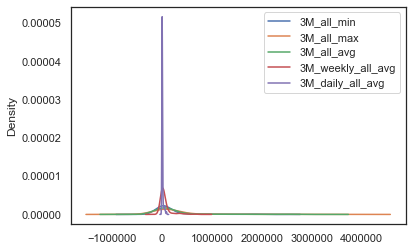

In [24]:
sample_month_3_df = months_3_df.sample(100)
sample_month_3_df.plot.kde()

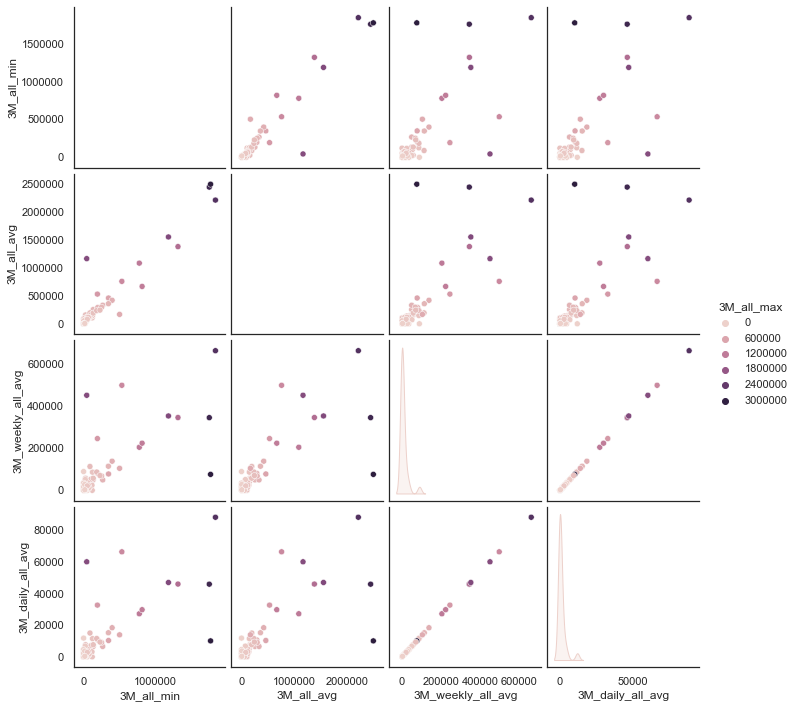

In [25]:
sns.pairplot(sample_month_3_df, hue="3M_all_max")
plt.show()

#### Prunning the columns based on the observations

In [26]:
revenue_df = train_df.filter(regex='gtv')
revenue_month_df = revenue_df.filter(regex='Months')
revenue_week_df = revenue_df.filter(regex='weeks')
revenue_day_df = revenue_df.filter(regex='days')
revenue_data = {
    'all_gtv_last12Months_mean': revenue_month_df.mean(axis=1),
    'all_gtv_last10weeks_mean': revenue_week_df.mean(axis=1),
    'all_gtv_last10days_mean': revenue_day_df.mean(axis=1)
}
train_df = train_df.drop(labels=revenue_df.columns.values, axis=1)
train_df = pd.concat([train_df, pd.DataFrame(revenue_data)], axis=1)
# train_df = train_df.drop(labels=train_df.filter(regex='gtv').columns.values, axis=1)

In [27]:
growth_norm_month_df = train_df.filter(regex='growth_m')
growth_mean = pd.Series(growth_norm_month_df.mean(axis=1), name="all_norm_growth_mean")
train_df = train_df.drop(labels=growth_norm_month_df.columns.values, axis=1)
train_df = pd.concat([train_df, growth_mean], axis=1)

In [28]:
train_df = train_df.drop(labels=train_df.filter(regex='3M_').columns.values, axis=1)

In [29]:
gap_df = train_df.filter(regex='gap')
gap_mean = pd.Series(gap_df.mean(axis=1), name="gaps_mean")
train_df = train_df.drop(labels=gap_df.columns.values, axis=1)
train_df = pd.concat([train_df, gap_mean], axis=1)

In [30]:
all_last_df = train_df.filter(regex='all_last')
all_last_mean = pd.Series(all_last_df.mean(axis=1), name="all_last_mean")
train_df = train_df.drop(labels=all_last_df.columns.values, axis=1)
train_df = pd.concat([train_df, all_last_mean], axis=1)

In [31]:
all_ystrday_df = train_df.filter(regex='all_ystrday')
all_ystrday_mean = pd.Series(all_ystrday_df.mean(axis=1), name="all_ystrday_mean")
train_df = train_df.drop(labels=all_ystrday_df.columns.values, axis=1)
train_df = pd.concat([train_df, all_ystrday_mean], axis=1)

In [32]:
all_mrr_df = train_df.filter(regex='all_mrr')
all_mrr_mean = pd.Series(all_mrr_df.mean(axis=1), name="all_mrr_mean")
train_df = train_df.drop(labels=all_mrr_df.columns.values, axis=1)
train_df = pd.concat([train_df, all_mrr_mean], axis=1)

In [33]:
train_df = train_df.drop(labels=['all_seg', 'all_risk_cm', 
                                 'all_consistency_index', 'all_growth_index', 
                                 'all_norm_growth_index_last', 'all_7days_max_thisvs10w',
                                 'all_7days_vslast_month7days', 'all_7days_vslast7days', 
                                 'all_7days_mean_thisvs4w', 'all_7days_min_thisvs4w', 
                                 'all_7days_trend_vs10weeks', 'all_lst30days_vsmin_lst3m', 
                                 'all_mtd_vs_mean_lst3M', 'all_mtd_vs_min_lst3M'], axis=1)

#### Get the Train Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.2, random_state=42)

### Model Building

In [35]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
model.score(X_test, y_test)

0.8330328502475957

In [37]:
y_pred = model.predict(X_test)

### Analyzing the error

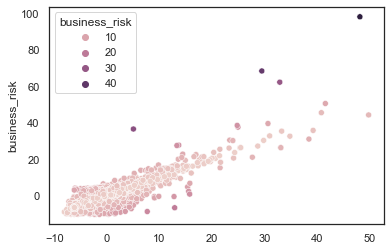

In [38]:
error_plot = sns.scatterplot(y_pred, np.squeeze(y_test), hue=abs(y_pred-np.squeeze(y_test)))
error_plot.figure.savefig("./visualization_images/error_plot.png")

In [39]:
y_test = np.squeeze(y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 1.2104367129572717
MSE: 4.643585524387962
RMSE: 2.1548980310882375
R-Squared: 0.8330328502475957


### Predicting for new input data

Make sure to convert the record into dict with key value and pass

In [40]:
input_data = prepare_input(test_df) 
input_pred = model.predict(input_data)
input_pred = pd.Series(data=input_pred, name="business_risk")
test_df = pd.concat([test_df, input_pred], axis=1)
test_df.to_csv('./assignment_data/assignment_predicted.csv', index=False)